In [1]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

### Read bus timetable data

In [2]:
routes_df = pd.read_csv('data/bus_timetable/routes.txt')
routes_df = routes_df[['route_id', 'route_short_name', 'route_long_name']]
routes_df.head()

route_id route_short_name                          route_long_name
0  3941_62982                4            Monkstown Avenue - Harristown
1  3941_62983                6      Howth Dart Stn - Lower Abbey Street
2  3941_62984               11        Sandyford Ind Estate - Wadelai Pk
3  3941_62985               13               Grange Castle - Harristown
4  3941_62986               14  Dundrum Luas Stn - Ardlea Rd (Beaumont)

In [3]:
trips_df = pd.read_csv('data/bus_timetable/trips.txt')
trips_df.head()

route_id  service_id     trip_id trip_headsign  trip_short_name  \
0  3941_63061         285      3941_1   Shaw street             5875   
1  3941_63061         285     3941_10   Shaw street             5935   
2  3941_63061         120    3941_100   Shaw street            12521   
3  3941_63057         285   3941_1000     Ashington             7891   
4  3941_63014         120  3941_10000      Abbey St            13146   

   direction_id              block_id  shape_id  
0             0  3941_7778195_9001001    3941_1  
1             0  3941_7778195_9001009    3941_1  
2             0  3941_7778195_9001003    3941_1  
3             1  3941_7778195_7122021   3941_33  
4             1  3941_7778195_5041004  3941_320

In [4]:
stops_df = pd.read_csv('data/bus_timetable/stops.txt')
stops_df = stops_df[['stop_id', 'stop_name', 'stop_lat', 'stop_lon']]
stops_df.head()

stop_id           stop_name  stop_lat  stop_lon
0  822008203      Visitor Centre  53.36469  -6.33167
1  822008204  Áras an Uachtaráin  53.35969  -6.32456
2  822008205          Dublin Zoo  53.35173  -6.30548
3  822008206          Park Gates  53.34884  -6.29777
4  822008208          Park Gates  53.34872  -6.29792

In [5]:
stop_times_df = pd.read_csv('data/bus_timetable/stop_times.txt')
stop_times_df = stop_times_df[['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence']]
stop_times_df.head()

trip_id arrival_time departure_time       stop_id  stop_sequence
0  3941_1     06:30:00       06:30:00  8240DB000226              1
1  3941_1     06:31:04       06:31:04  8220DB000228              2
2  3941_1     06:31:59       06:31:59  8240DB000229              3
3  3941_1     06:33:24       06:33:24  8240DB000227              4
4  3941_1     06:34:19       06:34:19  8240DB000230              5

### Work with line 46a

In [6]:
route_46a_id = routes_df[routes_df['route_short_name'] == '46A']['route_id'].values[0]
trips_46a_df = trips_df[trips_df['route_id'] == route_46a_id]
trips_46a_df = trips_46a_df[trips_46a_df['direction_id'] == 0].reset_index(drop=True)
trips_46a_df.head()

route_id  service_id     trip_id  trip_headsign  trip_short_name  \
0  3941_63024         285  3941_10892            UCD             2073   
1  3941_63024         285  3941_10893  Dun Laoghaire             1775   
2  3941_63024         285  3941_10894  Dun Laoghaire             1860   
3  3941_63024         285  3941_10895  Dun Laoghaire             2058   
4  3941_63024         285  3941_10896  Dun Laoghaire             1736   

   direction_id              block_id  shape_id  
0             0  3941_7778195_2832101  3941_375  
1             0  3941_7778195_2046004  3941_371  
2             0  3941_7778195_2046007  3941_371  
3             0  3941_7778195_2046009  3941_371  
4             0  3941_7778195_2046011  3941_371

In [7]:
stop_times_46a_df = stop_times_df[stop_times_df['trip_id'].isin(trips_46a_df['trip_id'])].reset_index(drop=True)
# Substitute times starting with 24: with 00:
stop_times_46a_df['departure_time'] = stop_times_46a_df['departure_time'].str.replace('^24:', '00:')
stop_times_46a_df['arrival_time'] = stop_times_46a_df['arrival_time'].str.replace('^24:', '00:')
# Convert times to datetime.time
stop_times_46a_df['arrival_time'] = pd.to_datetime(stop_times_46a_df['arrival_time'], format='%H:%M:%S').dt.time
stop_times_46a_df['departure_time'] = pd.to_datetime(stop_times_46a_df['departure_time'], format='%H:%M:%S').dt.time
stop_times_46a_df.head()

/var/folders/wh/fmhwy24d0pxf6bhd8bbrv2cr0000gn/T/ipykernel_3418/1139077646.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  stop_times_46a_df['departure_time'] = stop_times_46a_df['departure_time'].str.replace('^24:', '00:')
/var/folders/wh/fmhwy24d0pxf6bhd8bbrv2cr0000gn/T/ipykernel_3418/1139077646.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  stop_times_46a_df['arrival_time'] = stop_times_46a_df['arrival_time'].str.replace('^24:', '00:')


trip_id arrival_time departure_time       stop_id  stop_sequence
0  3941_10892     05:15:00       05:15:00  8220DB000807              1
1  3941_10892     05:16:10       05:16:10  8220DB000808              2
2  3941_10892     05:16:49       05:16:49  8220DB000809              3
3  3941_10892     05:17:51       05:17:51  8220DB000810              4
4  3941_10892     05:18:27       05:18:27  8220DB000811              5

### Formulate genetic algorithm

In [8]:
# Maximum number of bus services
max_services = stop_times_46a_df.groupby('stop_id').size().max()

# Number of stops
n_stops = stop_times_46a_df['stop_sequence'].max()

In [9]:
print('Maximum number of bus services:', max_services)
print('Number of stops:', n_stops)

Maximum number of bus services: 289
Number of stops: 59


In [10]:
# Do not use min() and max() because the last departure might br after midnight
first_departure = stop_times_46a_df[stop_times_46a_df['stop_sequence'] == 1]['departure_time'].values[0]
last_departure = stop_times_46a_df[stop_times_46a_df['stop_sequence'] == 1]['departure_time'].values[-1]
print(first_departure, last_departure)

05:15:00 23:30:00


In [11]:
# Create a chromosome with max_services genes
# Every gene is a possible line departure time for the first stop

# Calculate the seconds from first to last departure
first_departure_seconds = first_departure.hour * 3600 + first_departure.minute * 60 + first_departure.second
last_departure_seconds = last_departure.hour * 3600 + last_departure.minute * 60 + last_departure.second
diff_seconds = last_departure_seconds - first_departure_seconds

# Choose n_services random times between first and last departure
n_services = max_services
population_size = 100
population = []
for i in range(population_size):
    chromosome = np.random.randint(0, diff_seconds, n_services)
    chromosome = np.sort(chromosome)
    population.append({'chromosome': chromosome})

In [12]:
def generate_population(population_size, genes, max_value):
    population = []
    for i in range(population_size):
        chromosome = np.random.randint(0, max_value, genes)
        chromosome = np.sort(chromosome)
        population.append({'chromosome': chromosome})
    return population

In [13]:
# Calculate the value of two objective functions for each chromosome
# f1 = actual number of services
# f2 = sum of expected waiting times (half sum of differences between consecutive services)

def f1(chromosome):
    return len(chromosome)

def f2(chromosome):
    return np.sum(np.diff(chromosome)) / 2

def fitness(chromosome):
    return f1(chromosome), f2(chromosome)

In [14]:
def non_dominated_ranking(population):
    ranked_population = []
    curr_rank_idx = 1
    curr_values = population.copy()
    next_round_values = []
    while len(curr_values) > 0:
        for i, chromosome in enumerate(curr_values):
            dominated = False
            for j, chromosome_ in enumerate(curr_values):
                if i == j:
                    continue
                if (chromosome['f1'] > chromosome_['f1'] and chromosome['f2'] >= chromosome_['f2']) or (chromosome['f1'] >= chromosome_['f1'] and chromosome['f2'] > chromosome_['f2']):
                    dominated = True
                    break
            if dominated:
                next_round_values.append(chromosome)
            else:
                chromosome['rank'] = curr_rank_idx
                ranked_population.append(chromosome)
        curr_rank_idx += 1
        curr_values = next_round_values.copy()
        next_round_values = []
    return ranked_population

In [15]:
def tournament_selection(population, tournament_size):
    tournament = random.choices(population, k=tournament_size)
    ranked_tournament = sorted(tournament, key=lambda x: x['rank'], reverse=True)
    return ranked_tournament[0], ranked_tournament[1]

In [16]:
def crossover(chromosome1, chromosome2, max_diff):
    crossover_point = random.randint(0, min(len(chromosome1), len(chromosome2)))
    new_chromosome1 = np.concatenate((chromosome1[:crossover_point], chromosome2[crossover_point:]))
    new_chromosome2 = np.concatenate((chromosome2[:crossover_point], chromosome1[crossover_point:]))

    new_chromosomes = []
    for c in [new_chromosome1, new_chromosome2]:
        overlap_flag = np.any(np.diff(c) < 0)
        if overlap_flag:
            overlap_start_idx = np.where(np.diff(c) < 0)[0][0]
            if c[overlap_start_idx] == np.max(c):
                overlap_end_idx = overlap_start_idx
            else:
                overlap_end_idx = np.where(c - c[overlap_start_idx] > 0)[0][0]
            new_chromosome = np.concatenate((c[:overlap_start_idx], c[overlap_end_idx:]))
            new_chromosomes.append(new_chromosome)
        else:
            if np.max(np.diff(c)) < max_diff:
                new_chromosomes.append(c)
                
    return new_chromosomes

In [17]:
def mutation(chromosome, mutation_rate, max_value, max_diff):
    while True:
        for i in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[i] = random.randint(0, max_value)
        chromosome = np.sort(chromosome)
        if np.max(np.diff(chromosome)) < max_diff:
            break
    return chromosome

In [18]:
def elitism(population, elite_size):
    elite = sorted(population, key=lambda x: (x['rank'], x['f2']))[:elite_size]
    return elite

In [26]:
def check_target(population, f1_target):
    f1_values = [x['f1'] for x in population]
    values_below_target = [x for x in f1_values if x <= f1_target]
    return len(values_below_target) > len(population) / 2

In [27]:
def genetic_algorithm(population_size, genes, mutation_rate, n_generations, max_value, max_diff, tournament_size, f1_target):
    # pbar = tqdm(total=n_generations)
    population = generate_population(population_size, genes, max_value)
    generation = 0
    pareto_solutions = [population]
    while generation < n_generations:
        print('Generation:', generation)
        for chromosome in population:
            chromosome['f1'], chromosome['f2'] = fitness(chromosome['chromosome'])
        parent_population = non_dominated_ranking(population)
        offspring_population = []
        while len(offspring_population) < population_size:
            parent1, parent2 = tournament_selection(parent_population, tournament_size)
            children = crossover(parent1['chromosome'], parent2['chromosome'], max_diff)
            for child in children:
                child = mutation(child, mutation_rate, max_value, max_diff)
                offspring_population.append({'chromosome': child})
        for chromosome in offspring_population:
            chromosome['f1'], chromosome['f2'] = fitness(chromosome['chromosome'])
        offspring_population = non_dominated_ranking(offspring_population)
        new_population = elitism(parent_population + offspring_population, population_size)
        pareto_solutions.append(new_population)
        population = new_population
        generation += 1
        if check_target(population, f1_target):
            break
        # pbar.update(1)
    # pbar.close()
    return pareto_solutions

In [28]:
populations = genetic_algorithm(
    population_size=100, 
    genes=2*n_services, 
    mutation_rate=0.1, 
    n_generations=100, 
    max_value=diff_seconds, 
    max_diff=1800, 
    tournament_size=5,
    f1_target=n_services
)

Generation: 0
Generation: 1
Generation: 2
Generation: 3


Generation: 4
Generation: 5
Generation: 6
Generation: 7
Generation: 8
Generation: 9
Generation: 10
Generation: 11
Generation: 12
Generation: 13
Generation: 14
Generation: 15
Generation: 16
Generation: 17
Generation: 18
Generation: 19
Generation: 20
Generation: 21
Generation: 22
Generation: 23
Generation: 24
Generation: 25
Generation: 26
Generation: 27
Generation: 28
Generation: 29
Generation: 30
Generation: 31
Generation: 32
Generation: 33
Generation: 34
Generation: 35
Generation: 36
Generation: 37
Generation: 38
Generation: 39
Generation: 40
Generation: 41
Generation: 42
Generation: 43
Generation: 44
Generation: 45
Generation: 46
Generation: 47
Generation: 48
Generation: 49
Generation: 50
Generation: 51
Generation: 52
Generation: 53
Generation: 54
Generation: 55
Generation: 56
Generation: 57
Generation: 58
Generation: 59
Generation: 60
Generation: 61
Generation: 62
Generation: 63
Generation: 64
Generation: 65


/var/folders/wh/fmhwy24d0pxf6bhd8bbrv2cr0000gn/T/ipykernel_3418/3311985290.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis')(norm_ranks)
/var/folders/wh/fmhwy24d0pxf6bhd8bbrv2cr0000gn/T/ipykernel_3418/3311985290.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('viridis')(norm_ranks)


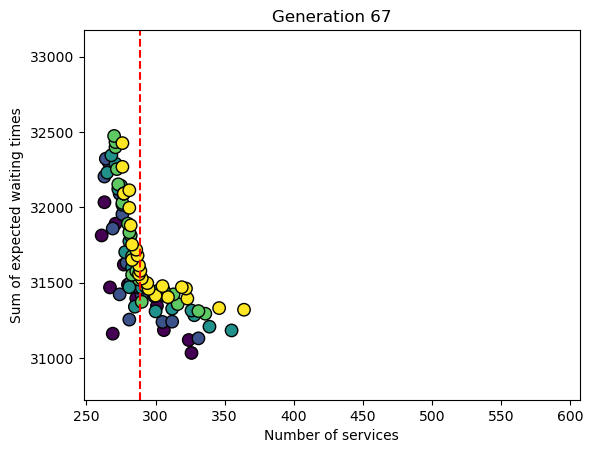

In [31]:
import matplotlib.cm as cm
import matplotlib.animation as animation
from IPython.display import HTML

# Find the minimum and maximum values of f1 and f2 in all populations
f1_values = []
f2_values = []
for population in populations:
    f1_values += [chromosome['f1'] for chromosome in population]
    f2_values += [chromosome['f2'] for chromosome in population]
f1_min, f1_max = min(f1_values), max(f1_values)
f2_min, f2_max = min(f2_values), max(f2_values)

def animate_pareto_solution(i):
    f1_values = [chromosome['f1'] for chromosome in populations[i]]
    f2_values = [chromosome['f2'] for chromosome in populations[i]]
    ranks = [chromosome['rank'] for chromosome in populations[i]]
    min_rank = min(ranks)
    max_rank = max(ranks)
    norm_ranks = [(rank - min_rank) / (max_rank - min_rank) for rank in ranks]
    colors = cm.get_cmap('viridis')(norm_ranks)
    ax.clear()
    scatter = ax.scatter(f1_values, f2_values, s=80, color=colors, edgecolors='black')
    ax.set_xlabel('Number of services')
    ax.set_ylabel('Sum of expected waiting times')
    ax.set_title(f'Generation {i+1}')
    ax.set_xlim(0.95* f1_min, 1.05*f1_max)
    ax.set_ylim(0.99*f2_min, 1.01*f2_max)
    ax.axvline(x=n_services, color='red', linestyle='--')
    return scatter,

fig, ax = plt.subplots()
ani = animation.FuncAnimation(fig, animate_pareto_solution, frames=len(populations), interval=500, blit=True)
# plt.show()
HTML(ani.to_jshtml())